In [66]:
import pandas as pd
from keras.models import load_model
import datasist as ds
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

In [87]:
path = './microdata.csv'
raw = pd.read_csv(path, encoding= 'unicode_escape')
raw

,Date,COURS_CLOTURE,COURS_AJUSTE,EVOLUTION,QUANTITE_ECHANGE,VOLUME
0,2021-2-12,697.9,697.9,0.27,433,302106.70
1,2021-2-11,696.0,696.0,0.00,110,76570.00
2,2021-2-10,696.0,696.0,1.44,1263,878654.00
3,2021-2-9,686.1,686.1,-0.92,595,409863.40
4,2021-2-8,692.5,692.5,-0.06,3000,2070524.30
...,...,...,...,...,...,...
195,2020-4-28,404.0,404.0,3.59,816,326018.00
196,2020-4-27,390.0,390.0,-2.50,148,57780.25
197,2020-4-24,400.0,400.0,0.00,51,20400.00
198,2020-4-23,400.0,400.0,0.05,19,7599.60


In [68]:
cours = raw.iloc[:,0:2]
cours['Date'] =  pd.to_datetime(cours['Date'])
cours = cours.sort_values(by='Date')
cours.reset_index(inplace=True)
del cours['index']

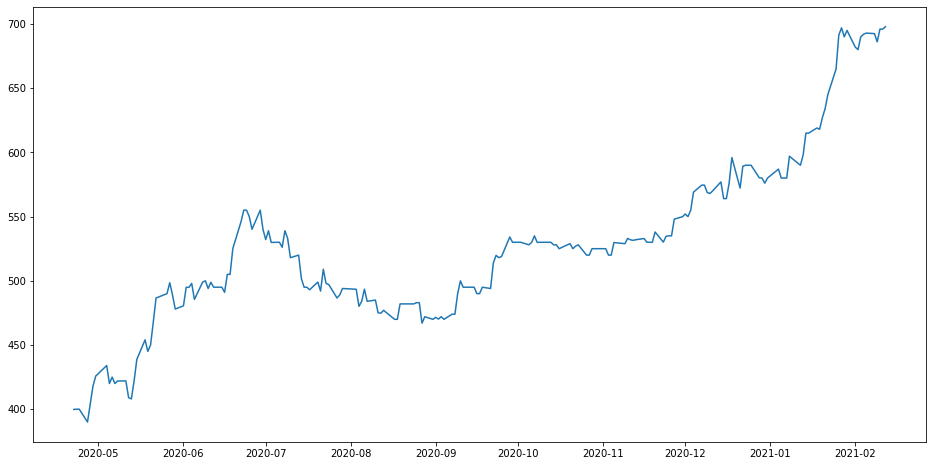

In [69]:
plt.figure(figsize=(16,8))
plt.plot(cours.set_index('Date')['COURS_CLOTURE'])
plt.show()

In [70]:
data = cours.filter(['COURS_CLOTURE'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

In [71]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

In [72]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [73]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [74]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [75]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [76]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [77]:
model.fit(x_train,y_train,batch_size=1,epochs=5)

Epoch 1/100
100/100 [==============================] - 3s 16ms/step - loss: 0.0277
Epoch 2/100
100/100 [==============================] - 2s 16ms/step - loss: 0.0030
Epoch 3/100
100/100 [==============================] - 2s 16ms/step - loss: 0.0032
Epoch 4/100
100/100 [==============================] - 2s 15ms/step - loss: 0.0020
Epoch 5/100
100/100 [==============================] - 2s 16ms/step - loss: 0.0012
Epoch 6/100
100/100 [==============================] - 2s 21ms/step - loss: 0.0018
Epoch 7/100
100/100 [==============================] - 2s 20ms/step - loss: 9.3655e-04
Epoch 8/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0011
Epoch 9/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0024
Epoch 10/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0010
Epoch 11/100
100/100 [==============================] - 2s 19ms/step - loss: 8.7824e-04
Epoch 12/100
100/100 [==============================] - 2s 19ms/step - loss: 

100/100 [==============================] - 2s 19ms/step - loss: 5.1321e-04
Epoch 95/100
100/100 [==============================] - 2s 21ms/step - loss: 4.8044e-04
Epoch 96/100
100/100 [==============================] - 2s 23ms/step - loss: 6.4864e-04
Epoch 97/100
100/100 [==============================] - 2s 22ms/step - loss: 5.5166e-04
Epoch 98/100
100/100 [==============================] - 2s 19ms/step - loss: 5.1274e-04
Epoch 99/100
100/100 [==============================] - 2s 18ms/step - loss: 5.7833e-04
Epoch 100/100
100/100 [==============================] - 2s 18ms/step - loss: 6.3099e-04


In [78]:
filename = 'my_model.h5'
model.save(filename)
del model

In [79]:
model = load_model('my_model.h5')

In [80]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [81]:
x_test = np.array(x_test)

In [82]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [83]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [84]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3.8166567993164078

C:\Users\u957205\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


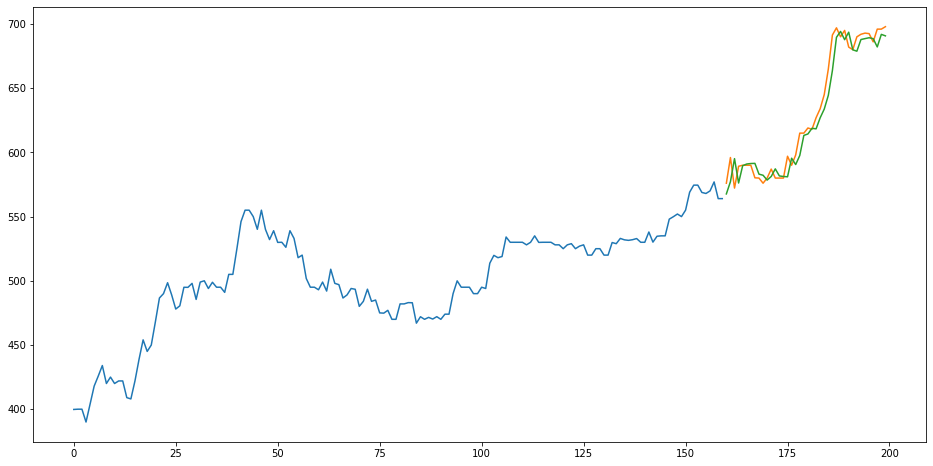

In [85]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.plot(train['COURS_CLOTURE'])
plt.plot(valid[['COURS_CLOTURE','Predictions']])

In [86]:
#predict price in the next open maret day
new_df = data[-60:].values
new_df_scaled = scaler.transform(new_df)
X_test = []
X_test.append(new_df_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[692.754]]
